In [1]:
# Standard
from pathlib import Path
import os
import sys
import warnings
import random
import dataclasses
import math
import multiprocessing as mp

# Extra
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
import statsmodels.stats.api as sms
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from keras.utils import plot_model
from keras.optimizers import Adam, SGD,RMSprop
from keras.models import load_model
from keras.callbacks import Callback
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import tensorflow as tf
import numpy as np
from tensorflow import keras as k
from tensorflow.keras import layers
# Custom
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are loaded from separate notebook:
%run utils.ipynb

# Configure Data Loading & Seed
SEED = 712  # Used for every random function
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
EXCLUDE_COLS = ["sys_time"]
CORES = mp.cpu_count()

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn"  # Cached data & csvs
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis
REPORT_PATH.mkdir(parents=True, exist_ok=True)

# Improve performance of Tensorflow (this improved speed _a_lot_ on my machine!!!)
K.tf.set_random_seed(SEED)
conf = K.tf.ConfigProto(
    device_count={"CPU": CORES},
    allow_soft_placement=True,
    intra_op_parallelism_threads=CORES,
    inter_op_parallelism_threads=CORES,
)
K.set_session(K.tf.Session(config=conf))

# Plotting
%matplotlib inline
utils_set_output_style()

# Silence various deprecation warnings...
tf.logging.set_verbosity(tf.logging.ERROR)
np.warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [1]:
!pip install --user install tensorflow==1.14.1

^C
ERROR: Operation cancelled by user


In [13]:
# from git 

def make_model(SIZE=28, LATENT_DIM=10, LR=1e-4, BETA=1.):
    encoder_inputs = layers.Input(shape=(SIZE, SIZE, 1), name='encoder_input')
    e = layers.Conv2D(filters=16,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(encoder_inputs)
    e = layers.BatchNormalization()(e)
    e = layers.Conv2D(filters=32,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(e)
    e = layers.BatchNormalization()(e)
    e = layers.Flatten()(e)
    z_mean = layers.Dense(LATENT_DIM, name='z_mean')(e)
    z_log_var = layers.Dense(LATENT_DIM, name='z_log_var')(e)
    encoder = k.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var], name='encoder')


    decoder_inputs = layers.Input(shape=(LATENT_DIM,), name='decoder_input')
    d = layers.Dense(units=7*7*4,activation='relu')(decoder_inputs)
    d = layers.Reshape((7,7,4))(d)
    d = layers.Conv2DTranspose(filters=16,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(d)
    d = layers.Conv2DTranspose(filters=32,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(d)
    decoded = layers.Conv2DTranspose(filters=1, kernel_size=3,strides=(1, 1), padding="SAME")(d)
    decoder = k.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')


    def sample(inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    sampler = layers.Lambda(sample)
    z = sampler([z_mean, z_log_var])
    vae = k.Model(inputs=encoder_inputs, outputs=decoder(z), name='vae')

    def compute_kernel(x, y):
        x_size = tf.shape(x)[0]
        y_size = tf.shape(y)[0]
        dim = tf.shape(x)[1]
        tiled_x = tf.tile(tf.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
        tiled_y = tf.tile(tf.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
        return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))


    def compute_mmd(x, y):
        x_kernel = compute_kernel(x, x)
        y_kernel = compute_kernel(y, y)
        xy_kernel = compute_kernel(x, y)
        return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

    true_samples = tf.random_normal(shape=tf.shape(z))
    loss_mmd = compute_mmd(true_samples, z)
    vae.add_loss(loss_mmd*BETA)
        
    vae.compile(loss='mse', optimizer=k.optimizers.Adam(LR), metrics=['mse'])
    return encoder, decoder , vae


In [14]:
#converting vae to a tf lite interpreter 
import tensorflow as tf
from pyod.models.vae import VAE
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
session=tf.Session()
_,_,model = make_model()#AutoEncoder() #VAE([1,16],[16,1],epochs=10) 
X_train, y_train = generate_data(behaviour='new', n_features=300, train_only=True)




(train_images, y_train), (test_images, y_test) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape((-1,28,28,1)).astype('float32')
test_images = test_images.reshape((-1,28,28,1)).astype('float32')
train_images /= 255.
test_images /= 255.

with session.as_default():
    with session.graph.as_default():
        model.fit(train_images, train_images, epochs=1, batch_size=128, verbose=0)#X_train)  

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz: None -- [Errno 101] Network is unreachable

In [ ]:
with session.as_default():
    with session.graph.as_default():
        model.model_.save(str(OUTPUT_PATH)+ "//"  + "model.h5")
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file( str(OUTPUT_PATH) + "//"  + "model.h5")
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

In [10]:
import pickle 
def ez_save_vae(autoenModel,model_path): 
    ##serialize model to JSON
    model_json = autoenModel.model_.to_json()
    with open(str(model_path) + "//" +"model.json", "w") as json_file:
        json_file.write(model_json)
    ##serialize weights to HDF5
    autoenModel.model_.save_weights(str(OUTPUT_PATH)+"//"+"model.h5")
    ##then set autoencoder model to None. It makes it smaller
    autoenModel.model_ = None
    with open(str(model_path)+"//"+"model"+'.pickle', 'wb') as handle:
        pickle.dump(autoenModel, handle, protocol=pickle.HIGHEST_PROTOCOL)

def ez_load_vae(model,path): 
    ##load the auto encoder instance
    with open(str(path) + "//" +"model" + ".pickle", 'rb') as handle:
        loaded_model = pickle.load(handle)
    # load json and create model
    json_file = open(str(path) + "//"  + 'model.json', 'r')
    loaded_model_json = json_file.read()
    loaded_model_json = loaded_model_json.replace("\"ragged\": false,", " ")
    json_file.close()
    loaded_model_ = tf.keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model_.load_weights(str(path) + "//"  + "model.h5")
    print("Loaded model from disk")
    loaded_model.model_= loaded_model_  ## Set the loaded model to the auto encoder instance model
    

    

ez_save_vae(model,OUTPUT_PATH)

edge_model = VAE([1,16],[16,1],epochs=10) 
ez_load_vae(edge_model,OUTPUT_PATH)

AttributeError: 'NoneType' object has no attribute 'get'

In [11]:
json_file = open(str(OUTPUT_PATH) + "//"  + 'model.json', 'r')
loaded_model_json = json_file.read()
#loaded_model_json = loaded_model_json.replace("\"ragged\": false,", " ")
json_file.close()
loaded_model_ = tf.keras.models.model_from_json(loaded_model_json)

AttributeError: 'NoneType' object has no attribute 'get'

In [80]:
json_file = open(str(OUTPUT_PATH) + "//"  + 'model.json', 'r')
loaded_model_json = json_file.read()
loaded_model_json = loaded_model_json.replace("\"ragged\": false,", " ")
json_file.close()
from keras.models import model_from_json
loaded_model_ = model_from_json(open(str(OUTPUT_PATH) + "//"  + 'model.json', 'r').read())

AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
model_copy= keras.models.clone_model(model.model_)
model_copy.build((None, 2)) # replace with number of variables in input layer
model_copy.compile(optimizer='adam', loss='mean_squared_error')
model_copy.set_weights(model.model_.get_weights())

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model_file(model.model_)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)


In [53]:
import keras 
from keras.models import load_model 
keras_file ="project.h5" 
keras.models.save_model(model.model_,keras_file) 
from tensorflow import lite 
coverter = lite.TFLiteConverter.from_keras_model_file(keras_file)

AttributeError: 'NoneType' object has no attribute 'get'

In [24]:
mooo_desc = [
    ##ipynbs 
    'AutoEncoder(epochs=300, contamination=.137)',
    'VAE(epochs=300, contamination=.137)',
    '1,16_contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=300,capacity=1',
    '1,16_contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=300,capacity=1',
    '1,16_contamination=.1,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=300,capacity=1',
    '1,16_contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=300,capacity=1',
    '1,16_contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=300,capacity=1',
    '1,16_contamination=.1,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=300,capacity=1',
    #non beta below 
    '1,16_contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=300,capacity=0',
    '1,16_contamination=.137,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=300,capacity=0',
    '1,16_contamination=.1,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=300,capacity=0',
    '1,16_contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=300,capacity=0',
    '1,16_contamination=.137,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=300,capacity=0',
    '1,16_contamination=.1,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=300,capacity=0',
    
    ##ipynbs 
    'AutoEncoder(epochs=500, contamination=.137)',
    'VAE(epochs=500, contamination=.137)',
    '1,2,16,32_contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=300,capacity=1',
    '1,2,16,32_contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=300,capacity=1',
    '1,2,16,32_contamination=.1,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=300,capacity=1',
    '1,2,16,32_contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=300,capacity=1',
    '1,2,16,32_contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=300,capacity=1',
    '1,2,16,32_contamination=.1,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=300,capacity=1',
    #non beta below 
    '1,2,16,32_contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=300,capacity=0',
    '1,2,16,32_contamination=.137,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=300,capacity=0',
    '1,2,16,32_contamination=.1,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=300,capacity=0',
    '1,2,16,32_contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=300,capacity=0',
    '1,2,16,32_contamination=.137,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=300,capacity=0',
    '1,2,16,32_contamination=.1,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=300,capacity=0',
    
    ##pys
    '1,16_contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1',
    '1,16_contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1',
    '1,16_contamination=.1,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1',
    '1,16_contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=95,capacity=1',
    '1,16_contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=95,capacity=1',
    '1,16_contamination=.1,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=95,capacity=1',
    #non beta below 
    '1,16_contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=95,capacity=0',
    '1,16_contamination=.137,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=95,capacity=0',
    '1,16_contamination=.1,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=95,capacity=0',
    '1,16_contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=95,capacity=0',
    '1,16_contamination=.137,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=95,capacity=0',
    '1,16_contamination=.1,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=95,capacity=0',
    
    ##pys
    '1,2,16,32_contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1',
    '1,2,16,32_contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1',
    '1,2,16,32_contamination=.1,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1',
    '1,2,16,32_contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=95,capacity=1',
    '1,2,16,32_contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=95,capacity=1',
    '1,2,16,32_contamination=.1,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=95,capacity=1',
    #non beta below 
    '1,2,16,32_contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=95,capacity=0',
    '1,2,16,32_contamination=.137,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=95,capacity=0',
    '1,2,16,32_contamination=.1,l2_regularizer=.5,gamma=1,dropout_rate=.25,epochs=95,capacity=0',
    '1,2,16,32_contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=95,capacity=0',
    '1,2,16,32_contamination=.137,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=95,capacity=0',
    '1,2,16,32_contamination=.1,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=95,capacity=0',

    'VAE()',
    "[16,1],[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
    "[16,1],[1,16],contamination=.22,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1", 
    "[16,1],[1,16],contamination=.25,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1", 
    "[16,1],[1,16],contamination=.27,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1", 
    "[16,1],[1,16],contamination=.3,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
    "[16,1],[1,16],contamination=.35,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1", 
    "[16,1],[1,16],contamination=.38,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1", 
    "[16,1],[1,16],contamination=.40,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1", 
    "[16,1],[1,16],contamination=.42,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1", 
    "[16,1],[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=80,capacity=1,", 
    "[16,1],[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=60,capacity=1,", 
    "[16,1],[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=40,capacity=1,", 
    "[16,1],[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=20,capacity=1,", 

 "[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=20,capacity=1,"  , 
]


mooo_desc = [
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=20,capacity=1,"  , 
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=40,capacity=1,"  , 
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=60,capacity=1,"  , 
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=80,capacity=1,"  , 
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=100,capacity=1,"  , 
    
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=20,capacity=0,"  , 
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=40,capacity=0,"  , 
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=60,capacity=0,"  , 
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=80,capacity=0,"  , 
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=100,capacity=0,"  , 
]



mooo_desc = [
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=100,capacity=0,"  , 
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=200,capacity=0,"  , 
    "[1,16],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=400,capacity=0,"  ,
      "[32,16,2,1],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=100,capacity=0,"  , 
    "[32,16,2,1],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=200,capacity=0,"  , 
    "[32,16,2,1],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=400,capacity=0,"  ,
      "[1,2,4,16,32],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=100,capacity=0,"  , 
    "[1,2,4,16,32],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=200,capacity=0,"  , 
    "[1,2,4,16,32],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=400,capacity=0,"  ,
      "[1,8],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=100,capacity=0,"  , 
    "[1,8],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=200,capacity=0,"  , 
    "[1,8],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=400,capacity=0,"  ,
      "[1,4],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=100,capacity=0,"  , 
    "[1,4],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=200,capacity=0,"  , 
    "[1,4],contamination=.2,l2_regularizer=.5,gamma=1,dropout_rate=0,epochs=400,capacity=0,"  ,
  
]

mooo_desc = [
    'VAE()',
    "[16,1],[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
    "abod_cont=.2",
    "knn_cont=.2",
    "ocsvm_cont=.2",
    "[16,1],[1,16],contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
    "abod_cont=.137",
    "knn_cont=.137",
    "ocsvm_cont=.137",]


mooo_desc = [
    "NODEEP_contamination=.137"  , 
    "NODEEP_contamination=.2"  , 
    "NODEEP_[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=400,capacity=1,"  , 
    "NODEEP_[1,16],contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=400,capacity=1,"  , 
   
]

mooo_desc = [
    "NODEEP_contamination=.137"  , 
    "NODEEP_contamination=.2"  ,     
    "NODEEP_contamination=.1"  , 
    "NODEEP_[1,16],contamination=.1,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=400,capacity=1,"  , 
    "NODEEP_[1,16],contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=400,capacity=1,"  , 
    "NODEEP_[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=400,capacity=1,"  , 

   
]
mooo_desc = [
    "NODEEP_contamination=.137"  , 
    "NODEEP_contamination=.2"  ,     
    "NODEEP_contamination=.1"  , 
    "NODEEP_[1,16],contamination=.1,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=400,capacity=1,"  , 
    "NODEEP_[1,16],contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=400,capacity=1,"  , 
    "NODEEP_[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=0,epochs=400,capacity=1,"  , 

   
]
mooo_desc = [
    "OneClassSVM(kernel=rbf)",
    " ABOD(contamination=.2,) ", 
 "KNN(contamination=.2,) ", 
 "LOF(contamination=.2,) ", 
 "LOCI(contamination=.2,) ", 
 "MCD(contamination=.2,) ", 
 "OCSVM(contamination=.2,) ", 
 "PCA(contamination=.2,) ",
]
mooo_desc = [
    " ABOD(contamination=.1,) ", 
 "KNN(contamination=.1,) ", 
 "LOF(contamination=.1,) ", 
 "LOCI(contamination=.1,) ", 
 "MCD(contamination=.1,) ", 
 "OCSVM(contamination=.1,) ", 
 "PCA(contamination=.1,) ",
] 
mooo_desc = [  
    'authors ocsvm', 
    'VAE()',
    "[16,1],[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
    "[16,1],[1,16],contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
     "knn_cont=.2",
    "knn_cont=.137",
    "abod_cont=.2",
    "abod_cont=.137",
    "lof cont=.2",
    "lof cont=.137",
    "ocsvm_cont=.2",
    "ocsvm_cont=.137",
]

mooo_desc = [
    "knn_cont=.3",
    "abod_cont=.3",
    "lof cont=.3",
    "ocsvm_cont=.3",
    'VAE()',
    "[16,1],[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
    "[16,1],[1,16],contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
     "knn_cont=.2",
    "knn_cont=.137",
    "abod_cont=.2",
    "abod_cont=.137",
    "lof cont=.2",
    "lof cont=.137",
    "ocsvm_cont=.2",
    "ocsvm_cont=.137",
]

mooo_desc = [
    " ABOD(contamination=.1,) ", 
 "KNN(contamination=.1,) ", 
 "LOF(contamination=.1,) ", 
 "LOCI(contamination=.1,) ", 
 "MCD(contamination=.1,) ", 
 "OCSVM(contamination=.1,) ", 
 "PCA(contamination=.1,) ",
] 

''''''
mooo_desc = [
]

mooo_desc = [
    'authors ocsvm', 
    #'VAE()',
    "[16,1],[1,16],contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
    #"[16,1],[1,16],contamination=.137,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,", 
     "knn_cont=.2",
    #"knn_cont=.137",
    "abod_cont=.2",
    #"abod_cont=.137",
    "lof cont=.2",
    #"lof cont=.137",
    "ocsvm_cont=.2",
    #"ocsvm_cont=.137",
 "MCD(contamination=.2,) ", 
 "PCA(contamination=.2,) ",




##naive 
 "MCD(contamination=.1,) ", 
 #"OCSVM(contamination=.1,) ", 
 "PCA(contamination=.1,) ",

    "[16,1],[1,16],contamination=.1,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,",
    "[16,1],[1,16],contamination=.13,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,",
    "[16,1],[1,16],contamination=.16,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,",
    "[16,1],[1,16],contamination=.19,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,",
    "[16,1],[1,16],contamination=.22,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,",
    "[16,1],[1,16],contamination=.25,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,",
    "[16,1],[1,16],contamination=.28,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,",
    "[16,1],[1,16],contamination=.31,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,",
    "[16,1],[1,16],contamination=.34,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,",
    
    
    "PCA(contamination=.1,)"
]




#OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn" / "NAIVESTD" # Cached data & csvs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn" / "VALIDFCNSTD2" # Cached data & csvs
for mooo in mooo_desc: 
    try: 
        #df_results=pd.read_csv(OUTPUT_PATH / f"VALID-FCN-MINMAX_test_results.csv")
        #df_results=pd.read_csv(OUTPUT_PATH / f"{mooo}_VAE_test_results.csv")
        #df_results=pd.read_csv(OUTPUT_PATH / f"{mooo}_VAE_NAIVE_test_results.csv")
        #df_results=pd.read_csv(OUTPUT_PATH / f"{mooo}_NODEEP_VAE_test_results.csv")
        
        #df_results=pd.read_csv(OUTPUT_PATH / f"{mooo}_nodeep_VAEFCN_test_results.csv")
        #df_results=pd.read_csv(OUTPUT_PATH / f"{mooo}_VAEFCN_test_results.csv")
        #df_results=pd.read_csv(OUTPUT_PATH / f"{mooo}4_NAIVE_test_results.csv")
        #df_results=pd.read_csv(OUTPUT_PATH / f"{mooo}4_NODEEP_NAIVE_test_results.csv")
        #df_results=pd.read_csv(OUTPUT_PATH / f"{mooo}4_test_results.csv")
        #df_results=pd.read_csv(OUTPUT_PATH / f"{mooo}4_nodeep_test_results.csv")
        df_results=pd.read_csv(OUTPUT_PATH / f"{mooo}5_nodeep_test_results.csv")
        
        
        
    except:
        continue
    print()
    print(str(mooo))
    print("EER= Mean {:.4f} Var {:.4f}".format(round(df_results["test_eer"].mean(), 4),(round(df_results["test_eer"].var(), 4))))
    print("F1= Mean {:.4f} Var {:.4f}".format(round(df_results["test_f1"].mean(), 4),(round(df_results["test_f1"].var(), 4))))
    print("Acc= Mean {:.4f} Var {:.4f}".format(round(df_results["test_accuracy"].mean(), 4),(round(df_results["test_accuracy"].var(), 4))))
    print("Time= Mean {:.4f} Var {:.4f}".format(round(df_results["score_time"].mean(), 4),(round(df_results["score_time"].var(), 4))))



[16,1],[1,16],contamination=.28,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=95,capacity=1,
EER= Mean 0.3453 Var 0.0253
F1= Mean 0.6294 Var 0.0754
Acc= Mean 0.6763 Var 0.0371
Time= Mean 0.0162 Var 0.0000

PCA(contamination=.1,)
EER= Mean 0.3586 Var 0.0291
F1= Mean 0.5021 Var 0.1133
Acc= Mean 0.6596 Var 0.0363
Time= Mean 0.0184 Var 0.0000


In [22]:
OUTPUT_PATH

PosixPath('/gpfs/fs0/scratch/u/uhengart/ezzeldi/vae_hmog/ContinAuth/notebooks/output/chapter-6-1-4-siamese-cnn/NAIVEROBUST')

### 1.2 Configuration <a id='1.2'>&nbsp;</a>

Number of inliers: 150
Number of outliers: 50
Ground truth shape is (200,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 K Nearest Neighbors (KNN)
Model 3 One-class SVM (OCSVM)
Model 4 VAE beta
Model 5 VAE 

1 fitting Angle-based Outlier Detector (ABOD)

2 fitting K Nearest Neighbors (KNN)

3 fitting One-class SVM (OCSVM)

4 fitting VAE beta
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19

InvalidArgumentError: Tensor input_19:0, specified in either feed_devices or fetch_devices was not found in the Graph

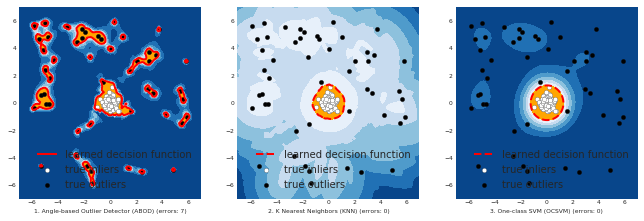

In [79]:
# -*- coding: utf-8 -*-
"""Compare all detection algorithms by plotting decision boundaries and
the number of decision boundaries.
"""
# Author: Yue Zhao <zhaoy@cmu.edu>
# License: BSD 2 clause

from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sos import SOS
from pyod.models.lscp import LSCP
from pyod.models.cof import COF
from pyod.models.sod import SOD
from pyod.models.vae import VAE

# TODO: add neural networks, LOCI, SOS, COF, SOD

# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print(
    'Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(
        shape=ground_truth.shape))
print(ground_truth, '\n')

random_state = 42
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
   ## 'Cluster-based Local Outlier Factor (CBLOF)':
    ##    CBLOF(contamination=outliers_fraction,
     ##         check_estimator=False, random_state=random_state),
  ##  'Feature Bagging':
  ##      FeatureBagging(LOF(n_neighbors=35),
   ##                    contamination=outliers_fraction,
    ##                   random_state=random_state),
   ## 'Histogram-base Outlier Detection (HBOS)': HBOS(
    ##    contamination=outliers_fraction),
   ## 'Isolation Forest': IForest(contamination=outliers_fraction,
    ##                            random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
   ## 'Average KNN': KNN(method='mean',
                ##       contamination=outliers_fraction),
    # 'Median KNN': KNN(method='median',
    #                   contamination=outliers_fraction),
    ##'Local Outlier Factor (LOF)':
       ## LOF(n_neighbors=35, contamination=outliers_fraction),
    # 'Local Correlation Integral (LOCI)':
    #     LOCI(contamination=outliers_fraction),
   ## 'Minimum Covariance Determinant (MCD)': MCD(
     ##   contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'VAE beta': VAE([16,1],[1,16],l2_regularizer=.5,gamma=1.5,epochs=900,contamination=outliers_fraction,capacity=1,batch_size=32),
    'VAE ': VAE([16,1],[1,16],epochs=900,contamination=outliers_fraction,batch_size=32),
   ## 'Principal Component Analysis (PCA)': PCA(
    ##    contamination=outliers_fraction, random_state=random_state),
    # 'Stochastic Outlier Selection (SOS)': SOS(
    #     contamination=outliers_fraction),
    ##'Locally Selective Combination (LSCP)': LSCP(
    ##    detector_list, contamination=outliers_fraction,
    ##    random_state=random_state),
    # 'Connectivity-Based Outlier Factor (COF)':
    #     COF(n_neighbors=35, contamination=outliers_fraction),
    # 'Subspace Outlier Detection (SOD)':
    #     SOD(contamination=outliers_fraction),
}

# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

# Fit the models with the generated data and
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 12))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print()
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.savefig('ALL.png', dpi=300)
plt.show()

In [4]:
# Workaround to remove ugly spacing between tqdm progress bars:
HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty{padding: 0;border: 0;} div.output_subarea{padding:0;}</style>")

In [5]:
#print(str(mooo)[:10])

df_results=pd.read_csv(OUTPUT_PATH / "1,2,16,32_contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=9500,capacity=1_VAEFCN_test_results.csv")

print("EER= Mean {:.4f} Var {:.4f}".format(round(df_results["test_eer"].mean(), 4),(round(df_results["test_eer"].var(), 4))))
print("Acc= Mean {:.4f} Var {:.4f}".format(round(df_results["test_accuracy"].mean(), 4),(round(df_results["test_accuracy"].var(), 4))))
print("Time= Mean {:.4f} Var {:.4f}".format(round(df_results["score_time"].mean(), 4),(round(df_results["score_time"].var(), 4))))


EER= Mean 0.3655 Var 0.0173
Acc= Mean 0.6539 Var 0.0219
Time= Mean 0.0076 Var 0.0000


### 1.3 Experiment Parameters <a id='1.3'>&nbsp;</a> 
Selection of parameters set that had been tested in this notebook. Select one of them to reproduce results.

In [5]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    step_width: int  # After resampling

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
    # Data / Splitting
    frequency=25,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z",
        "mag_x",
        "mag_y",
        "mag_z",
    ],
    max_subjects=90,
    exclude_subjects=[
        "733162",  # No 24 sessions
        "526319",  # ^
        "796581",  # ^
        "539502",  # Least amount of sensor values
        "219303",  # ^
        "737973",  # ^
        "986737",  # ^
        "256487",  # Most amount of sensor values
        "389015",  # ^
        "856401",  # ^
    ],
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=25,  # 1 sec
    step_width=25,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler="robust",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)

### 1.4 Select Approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

In [5]:
P = NAIVE_MINMAX_2D

In [6]:
utils_ppp(P)

,Value
batch_size,200
epochs_best,35
epochs_max,40
exclude_subjects,"[733162, 526319, 796581, 539502, 219303, 73797..."
feature_cols,"[acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z, mag..."
filters,"[32, 64, 128, 32]"
frequency,25
margin,0.2
max_pairs_per_session,60
max_subjects,90


## 2. Initial Data Preparation <a id='2'>&nbsp;</a> 

### 2.1 Load Dataset <a id='2.1'>&nbsp;</a> 

**Plot Distribution of EER per subject:**

In [6]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sos import SOS
from pyod.models.lscp import LSCP
from pyod.models.cof import COF
from pyod.models.sod import SOD
from pyod.models.xgbod import XGBOD
from pyod.models.vae import VAE


name="NAIVE-MINMAX-2D" 
cont = .1 
name="VALID-FCN-ROBUST-FINAL" 
cont = .2

%run utils.ipynb
from pathlib import Path
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn"  # Cached data & csvs
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis

import pandas as pd


In [48]:
modelss = [
    ABOD(contamination=cont,), 
    #CBLOF(contamination=cont,), 
    #FeatureBagging(contamination=cont,), 
    #HBOS(contamination=cont,), 
    #IForest(contamination=cont,), 
    KNN(contamination=cont,), 
    #LOF(contamination=cont,), 
    #MCD(contamination=cont,), 
    #OCSVM(contamination=cont,), 
    #PCA(contamination=cont,), 
    VAE([16,1],[1,16])
]
'''
name="VALID-FCN-ROBUST-FINAL" 
for mooo in modelss: 
    #print(str(mooo)[:10])
    try: 
        df_results=pd.read_csv(OUTPUT_PATH / f"{name+str(mooo)[:10]}_ALLMODELS_TEST_results.csv")
    except: 
        continue

    df_plot = df_results.rename(
        columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
    ).astype({"Owner": str})
    print(str(mooo)[:10])
    print("{:.4f}".format(round(df_results["test_eer"].mean(), 4)))
    print("{:.4f}".format(round(df_results["test_accuracy"].mean(), 4)))
    print("{:.4f}".format(round(df_results["score_time"].mean(), 4)))
    #fig = utils_plot_acc_eer_dist(df_plot, "Test EER") # with new archi [32,16,4,1],[1,4,16,32] instead of [32,16,8,4,1],[1,4,8,16,32]
    #utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{name+str(mooo)[:10]}-eer.pdf")
    #fig = utils_plot_acc_eer_dist(df_plot, "Test Accuracy")
    #utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{name+str(mooo)[:10]}-acc.pdf")
    #fig = utils_plot_acc_eer_dist(df_plot, "score_time")
    #utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{name+str(mooo)[:10]}-time.pdf")
print('==============')
'''    
name="NAIVE-MINMAX-2D"
#name="VALID-FCN-ROBUST-FINAL" 
cont=.1
print (name)
for mooo in modelss: 
    #print(str(mooo)[:10])
    try: 
        df_results=pd.read_csv(OUTPUT_PATH / f"{name+str(mooo)[:10]}2_ALLMODELS_TEST_results.csv")
    except: 
        continue
        
    

    #df_plot = df_results.rename(
    #    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
    #).astype({"Owner": str})
    print(str(mooo)[:10])

    print("EER= Mean {:.4f} Var {:.4f}".format(round(df_results["test_eer"].mean(), 4),(round(df_results["test_eer"].var(), 4))))
    print("Acc= Mean {:.4f} Var {:.4f}".format(round(df_results["test_accuracy"].mean(), 4),(round(df_results["test_accuracy"].var(), 4))))
    print("Time= Mean {:.4f} Var {:.4f}".format(round(df_results["score_time"].mean(), 4),(round(df_results["score_time"].var(), 4))))

    #fig = utils_plot_acc_eer_dist(df_plot, "Test EER") # with new archi [32,16,4,1],[1,4,16,32] instead of [32,16,8,4,1],[1,4,8,16,32]
    #utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{name+str(mooo)[:10]}-eer.pdf")
    #fig = utils_plot_acc_eer_dist(df_plot, "Test Accuracy")
    #utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{name+str(mooo)[:10]}-acc.pdf")
    #fig = utils_plot_acc_eer_dist(df_plot, "score_time")
    #utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{name+str(mooo)[:10]}-time.pdf")
    
    
print (" second run above first run down here") 
for mooo in modelss: 
    #print(str(mooo)[:10])
    try: 
        df_results=pd.read_csv(OUTPUT_PATH / f"{name+str(mooo)[:10]}_ALLMODELS_TEST_results.csv")
    except: 
        continue

    #df_plot = df_results.rename(
    #    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
    #).astype({"Owner": str})
    print(str(mooo)[:10])
    
    print("EER= Mean {:.4f} Var {:.4f}".format(round(df_results["test_eer"].mean(), 4),(round(df_results["test_eer"].var(), 4))))
    print("Acc= Mean {:.4f} Var {:.4f}".format(round(df_results["test_accuracy"].mean(), 4),(round(df_results["test_accuracy"].var(), 4))))
    print("Time= Mean {:.4f} Var {:.4f}".format(round(df_results["score_time"].mean(), 4),(round(df_results["score_time"].var(), 4))))


NAIVE-MINMAX-2D


KeyError: "['std_test_accuracy', 'std_test_eer', 'param_epochs', 'mean_test_accuracy', 'mean_test_eer'] not in index"

In [3]:
#print(str(mooo)[:10])

df_results=pd.read_csv(OUTPUT_PATH / "1,2,16,32_contamination=.2,l2_regularizer=.5,gamma=1.5,dropout_rate=.25,epochs=9500,capacity=1_VAEFCN_test_results.csv")

print("EER= Mean {:.4f} Var {:.4f}".format(round(df_results["test_eer"].mean(), 4),(round(df_results["test_eer"].var(), 4))))
print("Acc= Mean {:.4f} Var {:.4f}".format(round(df_results["test_accuracy"].mean(), 4),(round(df_results["test_accuracy"].var(), 4))))
print("Time= Mean {:.4f} Var {:.4f}".format(round(df_results["score_time"].mean(), 4),(round(df_results["score_time"].var(), 4))))


NameError: name 'OUTPUT_PATH' is not defined

In [51]:
x="NAIVE-MINMAX-2D"
for enc in encoder_architectures[::-1]: 
    if os.path.isfile(OUTPUT_PATH / f"{x+str(enc)}__VAE_ez_yes_params_in_construct__random_search_results_again.csv"): 
        print(enc)
        df_results = pd.read_csv(OUTPUT_PATH / f"{x+str(enc)}__VAE_ez_yes_params_in_construct__random_search_results_again.csv")
        
       
        display(
        df_results[df_results["owner"] == 785873][
            [
                "owner",
                "mean_test_eer",
                "std_test_eer",
                "param_epochs", 
                "mean_test_accuracy",
                "std_test_accuracy",
            ]
        ].sort_values("mean_test_eer").head(10)
        )    
            
            
        '''
        display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
            "owner",
            "rank_test_eer",
            "mean_fit_time",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
            ]
        ].sort_values("mean_test_eer").head(3) )
        '''    

NameError: name 'encoder_architectures' is not defined

In [ ]:
fig = utils_plot_acc_eer_dist(df_plot, "Test EER") # with new archi [32,16,4,1],[1,4,16,32] instead of [32,16,8,4,1],[1,4,8,16,32]
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-eer.pdf")

In [ ]:
fig = utils_plot_acc_eer_dist(df_plot, "mean_test_eer")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-eer.pdf")

### 7.3 Evaluate increasing Training Set Size (Training Delay) <a id='7.3'>&nbsp;</a> 

In [ ]:
training_set_sizes = [1, 2, 3, 4, 10, 30, 60, 90, 125, 175, 250, 375]  # In samples

deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for n_train_samples in tqdm(training_set_sizes, desc="Train Size", leave=False):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_test,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                limit_train_samples=n_train_samples,  # samples overall
                seed=SEED + i,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                deep_model=deep_feature_model,
                model_variant=P.model_variant,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_test["subject"].nunique(),
            leave=False,
        ):
            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values

            train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            model = VAE([32,16,8,4,1],[1,4,8,16,32], contamination=.5, optimizer='sgd',                
                gamma=3 , 
                capacity=.5 , 
                loss=losses.kld,
                batch_size=32, 
                dropout_rate=.25,
                epochs=200,
                output_activation=activations.selu, 
                hidden_activation=activations.sigmoid, 
    )

            warnings.filterwarnings("ignore")
            scores = cross_validate(
                model,
                X,
                y,
                cv=train_test_cv,
                scoring={"eer": utils_eer_scorer},
                n_jobs=CORES,
                verbose=0,
                return_train_score=True,
            )
            df_score = pd.DataFrame(scores)
            df_score["owner"] = owner
            df_score["train_samples"] = n_train_samples
            df_score["train_eer"] = df_score[
                "train_eer"
            ].abs()  # Revert scorer's signflip
            df_score["test_eer"] = df_score["test_eer"].abs()
            df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv", index=False)
df_results.head()

**Load Results from "Training set size" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv")
df_plot = (
    df_results[["test_eer", "owner", "train_samples"]]
    .groupby(["owner", "train_samples"], as_index=False)
    .mean()
    .astype({"owner": "category"})
    .rename(
        columns={
            "test_eer": "Test EER",
            "owner": "Owner",
        }
    )
)
df_plot["Training Data in Seconds"] = df_plot["train_samples"] * P.window_size / P.frequency

**Plot EER with increasing number of training samples:**

In [ ]:
utils_plot_training_delay(df_plot)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-train-size.pdf")

### 7.4 Evaluate increasing Test Set Sizes (Detection Delay)<a id='7.4'>&nbsp;</a> 

In [ ]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(50), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            limit_test_samples=1,  # Samples overall
            seed=SEED + i,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = VAE([32,16,8,4,1],[1,4,8,16,32], contamination=.5, optimizer='sgd',                
                gamma=3 , 
                capacity=.5 , 
                loss=losses.kld,
                batch_size=32, 
                dropout_rate=.25,
                epochs=200,
                output_activation=activations.selu, 
                hidden_activation=activations.sigmoid, 
    )

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["run"] = i
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv", index=False)
df_results.head()

**Load Results from "Detection Delay" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv")
df_results["owner"] = df_results["owner"].astype(str)
df_plot = df_results.copy()

**Plot Expanding Mean EER and confidence interval:**

In [ ]:
utils_plot_detect_delay(df_plot, factor=P.window_size / P.frequency, xlim=160)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-detection-delay.pdf"
)

In [30]:
df_results = pd.read_csv(OUTPUT_PATH/"VALID-FCN-ROBUST-FINALVAE(b, decoder_neurons=[1, 16, 64], dropout_rate=0.2,_random_srch_rzlts.csv") 

FileNotFoundError: [Errno 2] File b'/gpfs/fs0/scratch/u/uhengart/ezzeldi/vae_hmog/ContinAuth/notebooks/output/chapter-6-1-4-siamese-cnn/VALID-FCN-ROBUST-FINALVAE(b, decoder_neurons=[1, 16, 64], dropout_rate=0.2,_random_srch_rzlts.csv' does not exist: b'/gpfs/fs0/scratch/u/uhengart/ezzeldi/vae_hmog/ContinAuth/notebooks/output/chapter-6-1-4-siamese-cnn/VALID-FCN-ROBUST-FINALVAE(b, decoder_neurons=[1, 16, 64], dropout_rate=0.2,_random_srch_rzlts.csv'

# param 

[{(16, 500): [0, 0],
  (16, 1500): [0, 0],
  (16, 2500): [0, 0],
  (16, 3500): [0, 0],
  (16, 4500): [0, 0],
  (16, 5500): [0, 0],
  (16, 6500): [0, 0],
  (16, 7500): [0, 0],
  (16, 8500): [0, 0],
  (16, 9500): [0, 0],
  (32, 500): [0, 0],
  (32, 1500): [0, 0],
  (32, 2500): [0, 0],
  (32, 3500): [0, 0],
  (32, 4500): [0, 0],
  (32, 5500): [0, 0],
  (32, 6500): [0, 0],
  (32, 7500): [0, 0],
  (32, 8500): [0, 0],
  (32, 9500): [0, 0]},
 {(16, 500): [0, 0],
  (16, 1500): [0, 0],
  (16, 2500): [0, 0],
  (16, 3500): [0, 0],
  (16, 4500): [0, 0],
  (16, 5500): [0, 0],
  (16, 6500): [0, 0],
  (16, 7500): [0, 0],
  (16, 8500): [0, 0],
  (16, 9500): [0, 0],
  (32, 500): [0, 0],
  (32, 1500): [0, 0],
  (32, 2500): [0, 0],
  (32, 3500): [0, 0],
  (32, 4500): [0, 0],
  (32, 5500): [0, 0],
  (32, 6500): [0, 0],
  (32, 7500): [0, 0],
  (32, 8500): [0, 0],
  (32, 9500): [0, 0]},
 {(16, 500): [0, 0],
  (16, 1500): [0, 0],
  (16, 2500): [0, 0],
  (16, 3500): [0, 0],
  (16, 4500): [0, 0],
  (16, 5500):

In [20]:
!ls output/chapter-6-1-4-siamese-cnn *.csv | grep 'MCD'

ls: cannot access *.csv: No such file or directory
MCD(contamination=.1,) 4_NAIVE_test_results.csv
MCD(contamination=.1,) 4_NODEEP_NAIVE_test_results.csv
MCD(contamination=.1,) _VAE_NAIVE_test_results.csv
MCD(contamination=.2,) _NODEEP_VAE_test_results.csv
NAIVE-MINMAX-2DMCD(assume2_ALLMODELS_TEST_results.csv
NAIVE-MINMAX-2DMCD(assume_All_MODELS_random_search_results.csv
NAIVE-MINMAX-2DMCD(assume_ALLMODELS_TEST_results.csv
VALID-FCN-ROBUST-FINALMCD(assume2_ALLMODELS_TEST_results.csv
VALID-FCN-ROBUST-FINALMCD(assume_All_MODELS_random_search_results.csv
VALID-FCN-ROBUST-FINALMCD(assume_ALLMODELS_TEST_results.csv


In [178]:
modelss_valid_test

[]

In [ ]:
modelss_valid_rand=[]
modelss_valid_test=[]
modelss_valid_nonVAE=[]
modelss_valid_VAE=[]

In [179]:

for r in modelss_allVALIDS: 
    if "rando" not in r:
        modelss_valid_test.append(r)
    else: 
        modelss_valid_rand.append(r)

In [21]:
models_all_MCD=[ 
"MCD(contamination=.1,) 4_NAIVE_test_results.csv",
 "MCD(contamination=.1,) 4_NODEEP_NAIVE_test_results.csv",
 "MCD(contamination=.1,) _VAE_NAIVE_test_results.csv",
 "MCD(contamination=.2,) _NODEEP_VAE_test_results.csv",
 "NAIVE-MINMAX-2DMCD(assume2_ALLMODELS_TEST_results.csv",
 "NAIVE-MINMAX-2DMCD(assume_All_MODELS_random_search_results.csv",
 "NAIVE-MINMAX-2DMCD(assume_ALLMODELS_TEST_results.csv",
 "VALID-FCN-ROBUST-FINALMCD(assume2_ALLMODELS_TEST_results.csv",
 "VALID-FCN-ROBUST-FINALMCD(assume_All_MODELS_random_search_results.csv",
 "VALID-FCN-ROBUST-FINALMCD(assume_ALLMODELS_TEST_results.csv"
]

OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn" 
for mooo in models_all_MCD: 
    try: 
        df_results=pd.read_csv(OUTPUT_PATH / f"{mooo}")
    except:
        continue
    print()
    print(str(mooo))
    print("EER= Mean {:.4f} Var {:.4f}".format(round(df_results["test_eer"].mean(), 4),(round(df_results["test_eer"].var(), 4))))
    print("Acc= Mean {:.4f} Var {:.4f}".format(round(df_results["test_accuracy"].mean(), 4),(round(df_results["test_accuracy"].var(), 4))))
    print("Time= Mean {:.4f} Var {:.4f}".format(round(df_results["score_time"].mean(), 4),(round(df_results["score_time"].var(), 4))))



MCD(contamination=.1,) 4_NAIVE_test_results.csv
EER= Mean 0.5000 Var 0.0000
Acc= Mean 0.5000 Var 0.0000
Time= Mean 0.0135 Var 0.0002

MCD(contamination=.1,) 4_NODEEP_NAIVE_test_results.csv
EER= Mean 0.4853 Var 0.0002
Acc= Mean 0.5278 Var 0.0008
Time= Mean 0.0992 Var 0.0054

MCD(contamination=.1,) _VAE_NAIVE_test_results.csv
EER= Mean 0.4804 Var 0.0003
Acc= Mean 0.5368 Var 0.0009
Time= Mean 0.0792 Var 0.0046

MCD(contamination=.2,) _NODEEP_VAE_test_results.csv
EER= Mean 0.3538 Var 0.0221
Acc= Mean 0.6655 Var 0.0291
Time= Mean 0.0616 Var 0.0000

NAIVE-MINMAX-2DMCD(assume2_ALLMODELS_TEST_results.csv
EER= Mean 0.4996 Var 0.0000
Acc= Mean 0.5008 Var 0.0000
Time= Mean 0.0130 Var 0.0002

NAIVE-MINMAX-2DMCD(assume_All_MODELS_random_search_results.csv


KeyError: 'test_eer'

In [143]:
modelss_allVALIDS=[
"VALID-FCN-ROBUST-FINAL[16, 1]__VAE_ez_noparams_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[16, 1]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[16, 1]__VAE_ez_yes_params_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 1]__VAE_ez_noparams_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 1]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 1]__VAE_ez__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 1]__VAE_ez_yes_params_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 2, 1]__VAE_ez_noparams_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 2, 1]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 2, 1]__VAE_ez__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 2, 1]__VAE_ez_yes_params_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 2]__VAE__random_search_results.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 1]__VAE_ez_noparams_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 1]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 1]__VAE_ez__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 1]__VAE_ez_yes_params_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 2]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 2]__VAE__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4, 1]__VAE_ez_noparams_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4, 1]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4, 1]__VAE_ez__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4, 1]__VAE_ez_yes_params_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4, 1]__VAE_REV__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4, 2, 1]__VAE_ez_noparams_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4, 2, 1]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4, 2, 1]__VAE_ez__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4, 2, 1]__VAE_ez_yes_params_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4, 2, 1]__VAE_REV__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4, 2]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 16, 8, 4]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 1]__VAE_ez_noparams_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 1]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 1]__VAE_ez_yes_params_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 24, 16, 8, 4, 2, 1]__HMM_ez_random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 24, 16, 8, 4, 2, 1]__VAE_REV__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 2]__VAE_ez_noparams_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 2]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 2]__VAE_ez_yes_params_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[32, 2]__VAE__random_search_results.csv",
"VALID-FCN-ROBUST-FINAL[32, 4]__VAE__random_search_results.csv",
"VALID-FCN-ROBUST-FINAL[64, 1]__VAE_ez_(outsoft,lossmse,hiddentanh)_in_construct__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINAL[64, 1]__VAE_ez__random_search_results_again.csv",
"VALID-FCN-ROBUST-FINALABOD(conta_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALABOD(conta_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALABOD(contamination=0.1, method='fast', n_neighbors=5)_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALCBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None, contamination=0.1, n_clusters=8, n_jobs=1, random_state=None, use_weights=False)_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALCBLOF(alph_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALCBLOF(alph_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALCOF(contam_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALFeatureBag_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALFeatureBag_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALHBOS(alpha_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALHBOS(alpha_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALIForest(be_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALIForest(be_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALKNN(algori_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALKNN(algori_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALLOCI(alpha_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALLOF(algori_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALLOF(algori_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALMCD(assume2_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALMCD(assume_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALMCD(assume_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALOCSVM(cach_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALOCSVM(cach_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALPCA(contam_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALPCA(contam_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINAL_random_search_results.csv",
"VALID-FCN-ROBUST-FINALSOD(alpha=_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINALSOS(contam_All_MODELS_random_search_results.csv",
"VALID-FCN-ROBUST-FINAL_test_results.csv",
"VALID-FCN-ROBUST-FINALVAE[1,16,64]_random_srch_rzlts.csv",
"VALID-FCN-ROBUST-FINALVAE[1,16]_random_srch_rzlts.csv",
"VALID-FCN-ROBUST-FINALVAE[1,32]_random_srch_rzlts.csv",
"VALID-FCN-ROBUST-FINALVAE[1,4,32]_random_srch_rzlts.csv",
"VALID-FCN-ROBUST-FINALVAE(batch_2_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALVAE(batch__ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINALVAE(batch_size=3_ALLMODELS_TEST_results.csv",
"VALID-FCN-ROBUST-FINAL__VAE__random_search_results.csv",
"VALID-FCN-ROBUST-FINAL_VAE_test_results.csv",
]

In [161]:
mooo

'VALID-FCN-ROBUST-FINAL_VAE_test_results.csv'

In [160]:
df_results.keys()

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_output_activation', 'param_optimizer', 'param_loss', 'param_l2_regularizer', 'param_hidden_activation', 'param_gamma', 'param_epochs', 'param_dropout_rate', 'param_contamination', 'param_capacity', 'param_batch_size', '879155_test_eer', '785873_test_eer', '201848_test_eer', '368258_test_eer', '710707_test_eer', '186676_test_eer', '827212_test_eer', '815316_test_eer', '698266_test_eer', 'mean_test_eer', 'std_test_eer', 'rank_test_eer', '879155_test_accuracy', '785873_test_accuracy', '201848_test_accuracy', '368258_test_accuracy', '710707_test_accuracy', '186676_test_accuracy', '827212_test_accuracy', '815316_test_accuracy', '698266_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'owner', 'run', '264325_test_eer', '264325_test_accuracy'], dtype='object')

In [181]:
modelsss=[

"VALID-FCN-ROBUST-FINALVAE[1,16,64]_random_srch_rzlts.csv", 
"VALID-FCN-ROBUST-FINALVAE[1,4,32]_random_srch_rzlts.csv", 
"VALID-FCN-ROBUST-FINALVAE[1,32]_random_srch_rzlts.csv", 
"VALID-FCN-ROBUST-FINALVAE[1,16]_random_srch_rzlts.csv"
]

modelss = modelss_valid_test
test=0


epochsss=[500,1500,2500,3500,4500,5500,6500,7500,8500,9500]
batches=[16,32]
batches=[1]
epochsss=[1]
rr=[] 
for l in range(len(modelss)): 
    rr.append({})
for k in range(len(rr)):
    for b in batches: 
        for ep in epochsss: 
            rr[k][b,ep]=[0,0]

k=0
mini=1
maxi=0
for mooo in modelss: 
    if mooo == 'VALID-FCN-ROBUST-FINAL_VAE_test_results.csv':
        continue
    if 'VAE' not in mooo: 
        continue 
    if 'test' or 'TEST' in mooo: 
        test=1
    else: 
        test=0 
    df_results = pd.read_csv(OUTPUT_PATH / mooo)
    print(mooo)
    
    '''
    print("EER= Mean {:.4f} Var {:.4f}".format(round(df_results["mean_test_eer"].mean(), 4),(round(df_results["std_test_eer"].var(), 4))))
    print("Acc= Mean {:.4f} Var {:.4f}".format(round(df_results["mean_test_accuracy"].mean(), 4),(round(df_results["std_test_accuracy"].var(), 4))))

    df_results[df_results["param_epochs"] == 2500][
            [
                "mean_test_accuracy",
            ]
       ].sort_values("mean_test_eer").head(1)
    ''' 
    for b in batches: 
        for ep in epochsss: 
            #print(int(ep),int(b))
            if test==1: 
                df=df_results
                rr[k][b,ep][0]=df["test_eer"].mean()
                rr[k][b,ep][1]=df["test_accuracy"].mean()
                if df["test_accuracy"].mean() > maxi: 
                    maxi= df["test_accuracy"].mean()
                    maxi_k=k
                    maxi_b=b
                    maxi_ep=ep

                if df["test_eer"].mean() < mini: 
                    mini= df["test_eer"].mean()
                    mini_k=k
                    mini_b=b
                    mini_ep=ep
            else:
                df=df_results.loc[(df_results["rank_test_accuracy"] == 1)]
                #df=df_results.loc[(df_results["param_epochs"] == ep)&(df_results["param_batch_size"] == b)]
                #print("EER= Mean {:.4f} Var {:.4f}".format(round(df["mean_test_eer"].mean(), 4),(round(df["std_test_eer"].var(), 4))))
                #print("Acc= Mean {:.4f} Var {:.4f}".format(round(df["mean_test_accuracy"].mean(), 4),(round(df["std_test_accuracy"].var(), 4))))
                rr[k][b,ep][0]=df["mean_test_eer"].mean()
                rr[k][b,ep][1]=df["mean_test_accuracy"].mean()

                if df["mean_test_accuracy"].mean() > maxi: 
                    maxi= df["mean_test_accuracy"].mean()
                    maxi_k=k
                    maxi_b=b
                    maxi_ep=ep

                if df["mean_test_eer"].mean() < mini: 
                    mini= df["mean_test_eer"].mean()
                    mini_k=k
                    mini_b=b
                    mini_ep=ep
    k=k+1

VALID-FCN-ROBUST-FINALVAE(batch_2_ALLMODELS_TEST_results.csv
VALID-FCN-ROBUST-FINALVAE(batch__ALLMODELS_TEST_results.csv
VALID-FCN-ROBUST-FINALVAE(batch_size=3_ALLMODELS_TEST_results.csv


In [182]:
#VAEs_testvalid
print(maxi,maxi_k,maxi_b,maxi_ep)
print(mini,mini_k,mini_b,mini_ep)

0.6662862616310893 1 1 1
0.356974071266925 1 1 1


In [173]:
#VAEs_valid
print(maxi,maxi_k,maxi_b,maxi_ep)
print(mini,mini_k,mini_b,mini_ep)

0.7004913076341648 7 1 1
0.33006295155891235 7 1 1


In [174]:
modelss[7]

'VALID-FCN-ROBUST-FINAL[32, 16, 2, 1]__VAE_ez_noparams_in_construct__random_search_results_again.csv'

In [169]:
#randvalid
print(maxi,maxi_k,maxi_b,maxi_ep)
print(mini,mini_k,mini_b,mini_ep)

0.7523809523809524 42 1 1
0.28231821075746943 42 1 1


In [170]:
modelss[42]

'VALID-FCN-ROBUST-FINALABOD(conta_All_MODELS_random_search_results.csv'

In [166]:
#testvalid
print(maxi,maxi_k,maxi_b,maxi_ep)
print(mini,mini_k,mini_b,mini_ep)

0.7414340448823208 8 1 1
0.291574267298776 8 1 1


In [167]:
modelss[8]

'VALID-FCN-ROBUST-FINALMCD(assume_ALLMODELS_TEST_results.csv'

In [139]:
#allvalid 
print(maxi,maxi_k,maxi_b,maxi_ep)
# best acc so far is 1,32 with batch32 and epochs 5500 

0.7523809523809524 42 1 1


In [141]:
#allvalid 
print(mini,mini_k,mini_b,mini_ep)
# best eer so far is 1,16 with batch32 and epochs 9500 

0.28231821075746943 42 1 1


In [142]:
modelss[42]

'VALID-FCN-ROBUST-FINALABOD(conta_All_MODELS_random_search_results.csv'

In [109]:
rr[2][32,5500]

[0.354938901730488, 0.671957671957672]

In [108]:
rr[3][32,9500]

[0.35468621491346186, 0.6716931216931218]

In [111]:
mooo="VALID-FCN-ROBUST-FINALVAE[1,32]_random_srch_rzlts.csv", 
mooo="VALID-FCN-ROBUST-FINALVAE[1,16]_random_srch_rzlts.csv"
df_results = pd.read_csv(OUTPUT_PATH / mooo)
ep=500
b=32
df=df_results.loc[(df_results["param_epochs"] == ep)&(df_results["param_batch_size"] == b)]
print("EER= Mean {:.4f} Var {:.4f}".format(round(df["mean_test_eer"].mean(), 4),(round(df["std_test_eer"].var(), 4))))
print("Acc= Mean {:.4f} Var {:.4f}".format(round(df["mean_test_accuracy"].mean(), 4),(round(df["std_test_accuracy"].var(), 4))))

EER= Mean 0.3560 Var 0.0008
Acc= Mean 0.6710 Var 0.0004


In [102]:
def print_best_params_and_scores(rr): 
    

{(16, 500): [0.36357159484298796, 0.6611111111111112],
 (16, 1500): [0.3630649431374183, 0.6612433862433862],
 (16, 2500): [0.36264453732926916, 0.6617724867724867],
 (16, 3500): [0.36321293881082795, 0.6617724867724868],
 (16, 4500): [0.36298163970275654, 0.6619047619047618],
 (16, 5500): [0.3632524521659445, 0.6616402116402116],
 (16, 6500): [0.3630491498717968, 0.6619047619047619],
 (16, 7500): [0.36327442023849194, 0.6615079365079366],
 (16, 8500): [0.36309327627008015, 0.6616402116402116],
 (16, 9500): [0.3631112931107206, 0.6615079365079366],
 (32, 500): [0.3638491279572681, 0.6607142857142857],
 (32, 1500): [0.3639347722526097, 0.6605820105820106],
 (32, 2500): [0.3635670630905786, 0.660978835978836],
 (32, 3500): [0.3634975506125232, 0.6611111111111112],
 (32, 4500): [0.3637391341297499, 0.6611111111111112],
 (32, 5500): [0.3637101891473765, 0.6611111111111111],
 (32, 6500): [0.3631413870950591, 0.6613756613756613],
 (32, 7500): [0.3622653300576328, 0.6624338624338624],
 (32, 8

In [55]:
modelss=[

"VALID-FCN-ROBUST-FINALVAE[1,16,64]_random_srch_rzlts.csv", 
"VALID-FCN-ROBUST-FINALVAE[1,4,32]_random_srch_rzlts.csv", 
"VALID-FCN-ROBUST-FINALVAE[1,32]_random_srch_rzlts.csv", 
"VALID-FCN-ROBUST-FINALVAE[1,16]_random_srch_rzlts.csv"
]

OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn" 

for mooo in modelss: 
    df_results = pd.read_csv(OUTPUT_PATH / mooo)
    print(mooo)
    
    '''
        
    print("EER= Mean {:.4f} Var {:.4f}".format(round(df_results["mean_test_eer"].mean(), 4),(round(df_results["std_test_eer"].var(), 4))))
    print("Acc= Mean {:.4f} Var {:.4f}".format(round(df_results["mean_test_accuracy"].mean(), 4),(round(df_results["std_test_accuracy"].var(), 4))))

    
    ''' 
    display(
        df_results[df_results["owner"] == 785873][
            [
                "owner",
                "mean_test_eer",
                "std_test_eer",
                "param_epochs", 
                "mean_test_accuracy",
                "std_test_accuracy",
            ]
        ].sort_values("mean_test_eer").head(1)
    )
      
    print("Best results for each owner:")
    display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
                "owner",
                "mean_test_eer",
                "std_test_eer",
                "param_epochs", 
                "mean_test_accuracy",
                "std_test_accuracy",
                "param_epochs",
            ]
        ].sort_values("mean_test_eer").head(3)
    )

    
    print("\n\n\nMost relevant statistics:")
    display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
                "mean_fit_time",
                "mean_test_accuracy",
                "std_test_accuracy",
                "mean_test_eer",
                "std_test_eer",
                "param_epochs",
            ]
        ].describe()
    )
    

VALID-FCN-ROBUST-FINALVAE[1,16,64]_random_srch_rzlts.csv


,owner,mean_test_eer,std_test_eer,param_epochs,mean_test_accuracy,std_test_accuracy
41,785873,0.275875,0.106506,1500,0.765873,0.097525


Best results for each owner:


,owner,mean_test_eer,std_test_eer,param_epochs,mean_test_accuracy,std_test_accuracy,param_epochs
157,827212,0.225427,0.116185,7500,0.808201,0.133211,7500
41,785873,0.275875,0.106506,1500,0.765873,0.097525,1500
53,785873,0.275875,0.106506,3500,0.765873,0.097525,3500





Most relevant statistics:


,mean_fit_time,mean_test_accuracy,std_test_accuracy,mean_test_eer,std_test_eer,param_epochs
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,268.424267,0.652589,0.124859,0.369817,0.111617,5928.571429
std,153.792765,0.116632,0.022791,0.097989,0.018306,3081.315546
min,121.800812,0.478836,0.089635,0.225427,0.060385,1500.000000
25%,193.304797,0.557870,0.102573,0.287056,0.106588,2750.000000
50%,227.279949,0.683862,0.128490,0.342390,0.115395,7000.000000
75%,265.933067,0.754299,0.143391,0.452225,0.116041,8500.000000
max,641.560724,0.808201,0.154587,0.510397,0.148597,9500.000000


VALID-FCN-ROBUST-FINALVAE[1,4,32]_random_srch_rzlts.csv


,owner,mean_test_eer,std_test_eer,param_epochs,mean_test_accuracy,std_test_accuracy
42,785873,0.275875,0.106506,2500,0.765873,0.097525


Best results for each owner:


,owner,mean_test_eer,std_test_eer,param_epochs,mean_test_accuracy,std_test_accuracy,param_epochs
142,827212,0.225409,0.122611,2500,0.805556,0.142083,2500
42,785873,0.275875,0.106506,2500,0.765873,0.097525,2500
38,879155,0.321006,0.120471,8500,0.710317,0.131253,8500





Most relevant statistics:


,mean_fit_time,mean_test_accuracy,std_test_accuracy,mean_test_eer,std_test_eer,param_epochs
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000
mean,300.111888,0.626720,0.130897,0.392577,0.112805,5300.00000
std,150.696790,0.110397,0.019964,0.092532,0.016916,2426.04911
min,113.717769,0.478836,0.091891,0.225409,0.062400,1500.00000
25%,204.995898,0.510582,0.118981,0.326761,0.107641,3000.00000
50%,233.847738,0.645503,0.130410,0.396304,0.115395,5500.00000
75%,438.326323,0.702381,0.148873,0.489815,0.117933,7000.00000
max,562.788305,0.805556,0.154587,0.510397,0.144910,8500.00000


VALID-FCN-ROBUST-FINALVAE[1,32]_random_srch_rzlts.csv


,owner,mean_test_eer,std_test_eer,param_epochs,mean_test_accuracy,std_test_accuracy
50,785873,0.325887,0.126249,500,0.707672,0.128232


Best results for each owner:


,owner,mean_test_eer,std_test_eer,param_epochs,mean_test_accuracy,std_test_accuracy,param_epochs
146,827212,0.204486,0.142140,6500,0.833333,0.133748,6500
151,827212,0.204486,0.142140,1500,0.832011,0.133565,1500
125,186676,0.294770,0.121484,5500,0.740741,0.125459,5500





Most relevant statistics:


,mean_fit_time,mean_test_accuracy,std_test_accuracy,mean_test_eer,std_test_eer,param_epochs
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,218.920067,0.689394,0.115256,0.338539,0.107668,4045.454545
std,133.112899,0.086338,0.021114,0.080509,0.028155,2296.241989
min,34.104770,0.585979,0.078856,0.204486,0.066895,500.000000
25%,144.168518,0.621032,0.097121,0.306168,0.084768,2500.000000
50%,218.570939,0.691799,0.123392,0.334332,0.121484,5500.000000
75%,266.198068,0.724206,0.130898,0.404966,0.125712,5500.000000
max,454.131598,0.833333,0.141726,0.431424,0.142140,6500.000000


VALID-FCN-ROBUST-FINALVAE[1,16]_random_srch_rzlts.csv


,owner,mean_test_eer,std_test_eer,param_epochs,mean_test_accuracy,std_test_accuracy
58,785873,0.325451,0.126166,8500,0.707672,0.1286


Best results for each owner:


,owner,mean_test_eer,std_test_eer,param_epochs,mean_test_accuracy,std_test_accuracy,param_epochs
155,827212,0.204486,0.142140,5500,0.833333,0.133748,5500
135,186676,0.294218,0.122480,5500,0.740741,0.127204,5500
99,368258,0.317030,0.076905,9500,0.705026,0.080503,9500





Most relevant statistics:


,mean_fit_time,mean_test_accuracy,std_test_accuracy,mean_test_eer,std_test_eer,param_epochs
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,254.806760,0.674868,0.114871,0.351991,0.105413,6300.000000
std,181.582499,0.076549,0.020086,0.071009,0.025817,3614.784456
min,38.975368,0.584656,0.080503,0.204486,0.073016,500.000000
25%,180.809207,0.613757,0.098191,0.319135,0.081017,4750.000000
50%,219.473975,0.668651,0.120430,0.356995,0.108086,7000.000000
75%,286.127932,0.707011,0.128251,0.411789,0.125863,9500.000000
max,573.180895,0.833333,0.142906,0.429959,0.142140,9500.000000


In [70]:
def uutils_plot_randomsearch_results(df_results, n_top=1):
    # Prepare data for plotting
    df_plot = df_results[df_results["rank_test_eer"] <= n_top].rename(
        columns={
            "param_epochs": r"$\epochs$",
            "param_gamma": r"$\gamma$",
            "mean_test_accuracy": "Mean Test Acc.",
            "mean_test_eer": "Mean Test EER",
        }
    )
    df_plot["Mean Test EER"] = df_plot["Mean Test EER"] * -1  # Because fewer is more

    median_nu = df_plot[r"$\epochs$"].median()
    median_gamma = df_plot[r"$\epochs$"].median()

    # Plot
    fig = plt.figure(figsize=(5.473 / 1.3, 2), dpi=180)
    g = sns.scatterplot(
        x=r"$\epochs$",
        y=r"$\gamma$",
        data=df_plot,
        size="Mean Test EER",
        sizes=(7, 60),
        hue="Mean Test EER",
        alpha=1,
        #        palette="Blues",
        linewidth=0,
    )

    # Format Legend labels
    leg = g.get_legend()
    new_handles = [h for h in leg.legendHandles]
    new_labels = []
    for i, handle in enumerate(leg.legendHandles):
        label = handle.get_label()
        try:
            new_labels.append(f"{abs(float(label)):.3f}")
        except ValueError:
            new_labels.append("")

    # Plot mean values
    plt.plot(
        [-0.01, 0.31],
        [median_gamma, median_gamma],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        0.23,
        median_gamma * 1.7 ** 2,
        r"median($\epochs$)",
        fontsize=6,
        color="black",
        alpha=0.9,
    )
    plt.text(
        0.23,
        median_gamma * 1.2 ** 2,
        f"{median_gamma:.3f}",
        fontsize=5,
        color="black",
        alpha=0.9,
    )

    plt.plot(
        [median_nu, median_nu],
        [0.0001, 1000],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        median_nu + 0.005, 400, r"median($\epochs$)", fontsize=6, color="black", alpha=0.9
    )
    plt.text(
        median_nu + 0.005, 200, f"{median_nu:.3f}", fontsize=5, color="black", alpha=0.9
    )

    # Adjust axes & legend
    plt.yscale("log")
    plt.ylim(0.0001, 1000)
    plt.xlim(0, 0.305)
    plt.legend(
        new_handles,
        new_labels,
        bbox_to_anchor=(1.02, 1),
        loc=2,
        borderaxespad=0.0,
        title="Mean EER per Owner\n(Validation Results)",
        title_fontsize=5,
    )

    fig.tight_layout()
    return fig

In [10]:
df_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_output_activation,param_optimizer,param_loss,param_l2_regularizer,param_hidden_activation,param_gamma,param_epochs,param_dropout_rate,param_contamination,param_capacity,param_batch_size,879155_test_eer,785873_test_eer,201848_test_eer,368258_test_eer,710707_test_eer,186676_test_eer,827212_test_eer,815316_test_eer,698266_test_eer,mean_test_eer,std_test_eer,rank_test_eer,879155_test_accuracy,785873_test_accuracy,201848_test_accuracy,368258_test_accuracy,710707_test_accuracy,186676_test_accuracy,827212_test_accuracy,815316_test_accuracy,698266_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,264325_test_eer,264325_test_accuracy
0,44.716449,0.946053,0.037612,0.015437,<function softmax at 0x2aee6ae22e18>,sgd,<function mean_squared_error at 0x2aee6add8d08>,0.5,<function tanh at 0x2aee6ae331e0>,1.5,500,0.25,0.137,1,16,0.270833,0.485294,0.23913,0.406780,0.453125,0.300000,0.351852,0.513889,0.406780,0.380854,0.091130,2.0,0.761905,0.523810,0.785714,0.630952,0.571429,0.738095,0.690476,0.47619,0.630952,0.645503,0.101757,1,264325,0,NaN,NaN
1,109.801075,2.765361,0.022697,0.009667,<function softmax at 0x2aee6ae22e18>,sgd,<function mean_squared_error at 0x2aee6add8d08>,0.5,<function tanh at 0x2aee6ae331e0>,1.5,1500,0.25,0.137,1,16,0.255319,0.492754,0.23913,0.416667,0.453125,0.300000,0.351852,0.513889,0.416667,0.382156,0.094995,13.0,0.773810,0.511905,0.785714,0.619048,0.571429,0.738095,0.690476,0.47619,0.619048,0.642857,0.105439,15,264325,0,NaN,NaN
2,175.247235,4.848013,0.031980,0.008724,<function softmax at 0x2aee6ae22e18>,sgd,<function mean_squared_error at 0x2aee6add8d08>,0.5,<function tanh at 0x2aee6ae331e0>,1.5,2500,0.25,0.137,1,16,0.255319,0.492754,0.23913,0.416667,0.453125,0.300000,0.351852,0.513889,0.406780,0.381057,0.094646,5.0,0.773810,0.511905,0.785714,0.619048,0.571429,0.738095,0.690476,0.47619,0.630952,0.644180,0.105207,5,264325,0,NaN,NaN
3,243.487188,2.799758,0.021167,0.005925,<function softmax at 0x2aee6ae22e18>,sgd,<function mean_squared_error at 0x2aee6add8d08>,0.5,<function tanh at 0x2aee6ae331e0>,1.5,3500,0.25,0.137,1,16,0.270833,0.492754,0.23913,0.406780,0.453125,0.313725,0.375000,0.513889,0.406780,0.385780,0.090246,19.0,0.761905,0.511905,0.785714,0.630952,0.571429,0.726190,0.666667,0.47619,0.619048,0.638889,0.101482,19,264325,0,NaN,NaN
4,303.454199,3.601334,0.024455,0.010206,<function softmax at 0x2aee6ae22e18>,sgd,<function mean_squared_error at 0x2aee6add8d08>,0.5,<function tanh at 0x2aee6ae331e0>,1.5,4500,0.25,0.137,1,16,0.255319,0.485294,0.23913,0.416667,0.453125,0.300000,0.351852,0.513889,0.406780,0.380228,0.093692,1.0,0.773810,0.523810,0.785714,0.619048,0.571429,0.738095,0.690476,0.47619,0.630952,0.645503,0.103598,1,264325,0,NaN,NaN


In [71]:
uutils_plot_randomsearch_results(df_results)

ValueError: 
\epochs
^
Unknown symbol: \epochs (at char 0), (line:1, col:1)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2b8f6b28f7b8> (for post_execute):


ValueError: 
\epochs
^
Unknown symbol: \epochs (at char 0), (line:1, col:1)

ValueError: 
\epochs
^
Unknown symbol: \epochs (at char 0), (line:1, col:1)

<Figure size 757.8x360 with 1 Axes>

# plot distribution of testing data features 

## does it make sense our VAE assumes normal distibution? 

In [5]:
# Standard
from pathlib import Path
import os
import sys
import warnings
import random
import dataclasses
import math
import multiprocessing as mp

# Extra
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
import statsmodels.stats.api as sms
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from keras.utils import plot_model
from keras.optimizers import Adam, SGD,RMSprop
from keras.models import load_model
from keras.callbacks import Callback
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Custom
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are loaded from separate notebook:
%run utils.ipynb
# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn"  # Cached data & csvs
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)


@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    step_width: int  # After resampling

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
    # Data / Splitting
    frequency=25,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z",
        "mag_x",
        "mag_y",
        "mag_z",
    ],
    max_subjects=90,
    exclude_subjects=[
        "733162",  # No 24 sessions
        "526319",  # ^
        "796581",  # ^
        "539502",  # Least amount of sensor values
        "219303",  # ^
        "737973",  # ^
        "986737",  # ^
        "256487",  # Most amount of sensor values
        "389015",  # ^
        "856401",  # ^
    ],
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=25,  # 1 sec
    step_width=25,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler="robust",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)


P = VALID_FCN_ROBUST
P.name="VALID-FCN-ROBUST-FINAL"
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5") #feature_cols=["acc_x", "acc_y", "acc_z"]

NameError: name 'load_deep_feature_model' is not defined